### Imports

In [1]:
import os
import sys
import random

In [2]:
import time

In [3]:
import numpy as np

In [4]:
import torch
from torch.utils.data import Dataset

In [5]:
from torch import nn

In [6]:
from torch.nn import functional

In [7]:
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

In [8]:
from tqdm import tqdm

In [9]:
from datetime import datetime

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.style.use('dark_background')
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

#### `svetlanna`

In [11]:
from svetlanna.units import ureg

In [12]:
from svetlanna import SimulationParameters
from svetlanna.parameters import ConstrainedParameter

In [13]:
from svetlanna import Wavefront
from svetlanna.transforms import ToWavefront

In [14]:
from svetlanna.elements import FreeSpace, Aperture, RectangularAperture, DiffractiveLayer
from svetlanna.setup import LinearOpticalSetup
from svetlanna.detector import Detector, DetectorProcessorClf

In [15]:
from svetlanna.visualization import show_stepwise_forward

In [16]:
from svetlanna.clerk import Clerk

#### `src`

In [17]:
# dataset of wavefronts
from src.wf_datasets import DatasetOfWavefronts

In [18]:
# training and evaluation loops
from src.clf_loops import onn_train_clf, onn_validate_clf

# Optical Neural Network

In that example notebook we will try to realize a simple architecture of an optical neural network from the article [[1]](https://www.science.org/doi/10.1126/science.aat8084).

# <span style="color:red"> 1. Simulation parameters (TODO) </span>


First of all we need to specify simulation parameters for our task: they includes wavelength $\lambda$ and a numerical mesh (in our case it corresponds to a neuron size).

**<span style="color:red">Sources to use:</span>**
[[1]](https://www.science.org/doi/10.1126/science.aat8084) and its [Supplementary Material](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf), [[2]](https://ieeexplore.ieee.org/abstract/document/8732486) 

In [19]:
# TODO: specify all variables (now they are None's) using provided sources

In [20]:
c_const = 299_792_458 # [m / s]

In [21]:
working_frequency = 400 * ureg.GHz  # [Hz]
working_wavelength = c_const / working_frequency  # [m]

In [22]:
# neuron size (square)
neuron_size = 0.53 * working_wavelength  # [m]

In [23]:
print('Specified parameters:')
# uncomment next two lines!
print(f'lambda = {working_wavelength * 1e6:.3f} um')
print(f'neuron size = {neuron_size * 1e6:.3f} um') # IR

Specified parameters:
lambda = 749.481 um
neuron size = 397.225 um


In [24]:
# an actual zone where weights will be updated during a training process
ALL_SIZE = (200, 200)  # for example (100, 100) neurons
USE_APERTURES = False

In [25]:
if USE_APERTURES:
    # if we will add apertures we must specify the aperture size here!
    DETECTOR_SIZE = (None, None)
else:
    DETECTOR_SIZE = ALL_SIZE

In [26]:
# number of neurons in simulation
x_layer_nodes = ALL_SIZE[1]
y_layer_nodes = ALL_SIZE[0]

In [27]:
# calculate physical size of each layer in [m]
x_layer_size_m = x_layer_nodes * neuron_size  # [m]
y_layer_size_m = y_layer_nodes * neuron_size

In [28]:
print(f'Layer size (in neurons): {x_layer_nodes} x {y_layer_nodes} = {x_layer_nodes * y_layer_nodes}')
print(f'Layer size (in cm): {x_layer_size_m * 1e2} x {y_layer_size_m * 1e2}')

Layer size (in neurons): 200 x 200 = 40000
Layer size (in cm): 7.944500137 x 7.944500137


In [29]:
# simulation parameters for the rest of the notebook!

SIM_PARAMS = SimulationParameters(
    axes={
        "W" : torch.linspace(-x_layer_size_m / 2, x_layer_size_m / 2, x_layer_nodes),
        "H" : torch.linspace(-y_layer_size_m / 2, y_layer_size_m / 2, y_layer_nodes),
        "wavelength": working_wavelength
    }
)  # this is a custom object from our library `svetlanna`

# 2. Dataset preparation

## 2.1. [MNIST Dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

Here we load dataset of images but we need to transform them to Wavefronts in order to use them for DNN training!

In [30]:
# initialize a directory for a dataset
MNIST_DATA_FOLDER = './data'  # folder to store data

In [31]:
if not os.path.exists(MNIST_DATA_FOLDER):
    os.makedirs(MNIST_DATA_FOLDER)

### 2.1.1. Load Train and Test datasets of images

In [32]:
# TRAIN (images)
mnist_train_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=True,  # for train dataset
    download=True,
)

In [33]:
# TEST (images)
mnist_test_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=False,  # for test dataset
    download=True,
)

## 2.2. Create Train and Test datasets of wavefronts

From [[2]](https://ieeexplore.ieee.org/abstract/document/8732486):

> Input objects were encoded in amplitude channel (MNIST) of the input plane and were illuminated with a uniform plane wave at a wavelength of $\lambda$ to match the conditions introduced in [[1]](https://www.science.org/doi/10.1126/science.aat8084) for all-optical classification.

So, we need to do an amplitude modulation of each image from the dataset!

**<span style="color:red">Comment:</span>**
We will see later what does "amplitude modulation" mean!

In [34]:
# select modulation type
MODULATION_TYPE = 'amp'  # using ONLY amplitude to encode each picture in a Wavefront!

### 2.2.1. Transformations of images to Wavefronts

In [35]:
resize_y = int(DETECTOR_SIZE[0] / 2)
resize_x = int(DETECTOR_SIZE[1] / 2)  # shape for transforms.Resize

# paddings along OY
pad_top = int((y_layer_nodes - resize_y) / 2)
pad_bottom = y_layer_nodes - pad_top - resize_y
# paddings along OX
pad_left = int((x_layer_nodes - resize_x) / 2)
pad_right = x_layer_nodes - pad_left - resize_x  # params for transforms.Pad

In [36]:
# compose all transforms!
image_transform_for_ds = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # left padding
              pad_top,  # top padding
              pad_right,  # right padding
              pad_bottom  # bottom padding
          ),
          fill=0,
      ),  # padding to match sizes!
      ToWavefront(modulation_type=MODULATION_TYPE)  # <- select modulation type!!!
  ]  
)

### 2.2.2. Create Dataset objects for train and test datasets

In [37]:
# TRAIN dataset of WAVEFRONTS
mnist_wf_train_ds = DatasetOfWavefronts(
    init_ds=mnist_train_ds,  # dataset of images
    transformations=image_transform_for_ds,  # image transformation
    sim_params=SIM_PARAMS,  # simulation parameters
)

In [38]:
# TEST dataset of WAVEFRONTS
mnist_wf_test_ds = DatasetOfWavefronts(
    init_ds=mnist_test_ds,  # dataset of images
    transformations=image_transform_for_ds,  # image transformation
    sim_params=SIM_PARAMS,  # simulation parameters
)

In [39]:
print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


### <span style="color:red"> 2.2.3. Visualisation of dataset items (TODO) </span>

In [40]:
# TODO: What are the items of `mnist_train_ds`?

In [41]:
ind_ex = 0
mnist_train_ds[ind_ex][0]

In [42]:
mnist_wf_train_ds[ind_ex]

(Wavefront([[0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
            [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
            [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
            ...,
            [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
            [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
            [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j]]),
 5)

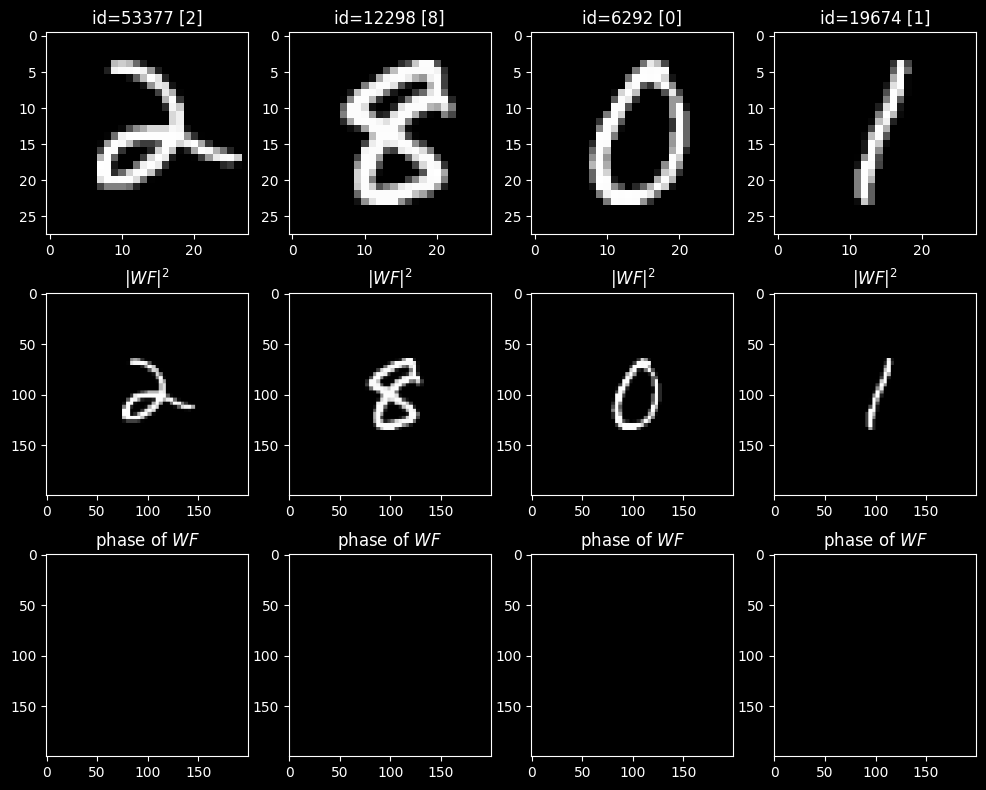

In [43]:
# plot several EXAMPLES from TRAIN dataset
n_examples= 4  # number of examples to plot
# choosing indecies of images (from train) to plot
random.seed(78)
train_examples_ids = random.sample(range(len(mnist_train_ds)), n_examples)

all_examples_wavefronts = []

n_lines = 3
fig, axs = plt.subplots(n_lines, n_examples, figsize=(n_examples * 3, n_lines * 3.2))
for ind_ex, ind_train in enumerate(train_examples_ids):
    image, label = mnist_train_ds[ind_train]
    
    axs[0][ind_ex].set_title(f'id={ind_train} [{label}]')
    axs[0][ind_ex].imshow(image, cmap='gray')

    wavefront, wf_label = mnist_wf_train_ds[ind_train]
    assert isinstance(wavefront, Wavefront)

    all_examples_wavefronts.append(wavefront)

    axs[1][ind_ex].set_title(f'$|WF|^2$')
    # here we can plot intensity for a wavefront
    axs[1][ind_ex].imshow(
        wavefront.intensity, cmap='gray',
        vmin=0, vmax=1
    )
    
    axs[2][ind_ex].set_title(f'phase of $WF$')
    axs[2][ind_ex].imshow(
        wavefront.phase, cmap='gray',
        vmin=0, vmax= 2 * torch.pi
    )

plt.show()

# <span style="color:red">3. Optical network (TODO)</span>

Using sources realize an architecture with several equidistant diffractive layers!

**<span style="color:red">Sources to use:</span>**
[[1]](https://www.science.org/doi/10.1126/science.aat8084) and its [Supplementary Material](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf), [[2]](https://ieeexplore.ieee.org/abstract/document/8732486) 

In [44]:
# TODO: specify all values
# Free space can be optimized.


In [45]:
NUM_OF_DIFF_LAYERS = 3  # number of diffractive layers
FREE_SPACE_DISTANCE = 40 * working_wavelength  # [m] - distance between difractive layers

In [46]:
print(f'Distance between layers is {FREE_SPACE_DISTANCE * 1e2:.3f} cm')

Distance between layers is 2.998 cm


## 3.1. Architecture

### 3.1.1. Elements


In [47]:
MAX_PHASE = 2 * np.pi

In [48]:
FREESPACE_METHOD = 'AS'  # we use an angular spectrum method

In [49]:
INIT_PHASES = torch.ones(NUM_OF_DIFF_LAYERS) * np.pi

#### Functions that return single elements for further architecture

In [50]:
# TAKE A LOOK! CODE HERE IS READY
def get_const_phase_layer(
    sim_params: SimulationParameters,
    value: float, 
    max_phase=2 * torch.pi
):
    """
    Returns DiffractiveLayer with a constant phase mask.
    """
    x_nodes, y_nodes = sim_params.axes_size(axs=('W', 'H'))

    const_mask = torch.ones(size=(y_nodes, x_nodes)) * value
    
    return DiffractiveLayer(
        simulation_parameters=sim_params,
        mask=ConstrainedParameter(
            const_mask,
            min_value=0,
            max_value=max_phase
        ),  # HERE WE ARE USING CONSTRAINED PARAMETER! Phases are learnable!
    )

### <span style="color:red">3.1.2. List of Elements (TODO)</span>

Function to construct a list of elements to reproduce an architecture from [the extended article](https://ieeexplore.ieee.org/abstract/document/8732486):

In [51]:
# TODO: add elements (using functions from 3.1.1.) in necessary places!

In [52]:
def get_elements_list(
    num_layers,
    simulation_parameters,
    freespace_method,
    phase_values,
    apertures=False,
    aperture_size=(100, 100)
):
    """
    Composes a list of elements for the setup.
    ...

    Parameters
    ----------
    num_layers : int
        Number of layers in the system.
    simulation_parameters : SimulationParameters()
        A simulation parameters for a task.
    freespace_method : str
        Propagation method for free spaces in a setup.
    phase_values : torch.Tensor()
        Torch tensor of phase values to generate constant masks for diffractive layers.
        
    apertures : bool
        If True, than before each DiffractiveLayer (and detector) we add a square aperture.
        Comment: there are strickt square apertures!
    aperture_size : tuple
        A size of apertures.
        
    Returns
    -------
    elements_list : list(Element)
        List of Elements for an optical setup.
    """
    elements_list = []  # list of elements

    # -------------------------------------------------- TODO AFTER THE LINE!
    # -----------------------------------------------------------------------
    
    elements_list.append( # This part is arguable
        FreeSpace(
            simulation_parameters=simulation_parameters,
            distance=FREE_SPACE_DISTANCE, # Here happens unnecessary blurring. Or not?
            method=freespace_method
        )
    )  # first FreeSpace layer before first DiffractiveLayer

    # several layers [Aperture + DiffractiveLayer + FreeSpace]
    for ind_layer in range(num_layers):

        # add square Aperture if needed
        if apertures:
            elements_list.append(
                RectangularAperture(simulation_parameters=simulation_parameters,
                                    size=aperture_size)
            )
            
        # add DiffractiveLayer (learnable phase mask) and FreeSpace
        elements_list.append(
            get_const_phase_layer(
                sim_params=simulation_parameters,
                value=phase_values[ind_layer],
                max_phase=MAX_PHASE
            )
        )
        elements_list.append(
            FreeSpace(
                simulation_parameters=simulation_parameters,
                distance=FREE_SPACE_DISTANCE,
                method=freespace_method
            )
        )

    # ----------------------------------------------------------- END OF TODO
    # -----------------------------------------------------------------------

    
    # -----------------------------------------------------------------------
    # add add square Aperture before Detector
    if apertures:
        elements_list.append(
            # your code...  # <-------------------------- HERE IS TODO TOO!!!
        )
    
    # adding a Detector in the end of the system
    # Detector returns torch.tensor of intencities (not a Wavefront - read documentation)
    elements_list.append(
        Detector(
            simulation_parameters=simulation_parameters,
            func='intensity'
        )
    )

    return elements_list

In [53]:
architecture_elements_list = get_elements_list(
    num_layers=NUM_OF_DIFF_LAYERS,
    simulation_parameters=SIM_PARAMS,
    freespace_method=FREESPACE_METHOD,
    phase_values=INIT_PHASES,
    apertures=USE_APERTURES,
    aperture_size=DETECTOR_SIZE
)
architecture_elements_list

[FreeSpace(),
 DiffractiveLayer(
   (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
 ),
 FreeSpace(),
 DiffractiveLayer(
   (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
 ),
 FreeSpace(),
 DiffractiveLayer(
   (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
 ),
 FreeSpace(),
 Detector()]

In [54]:
print(f'Number of elements in the system (including Detector): {len(architecture_elements_list)}')

Number of elements in the system (including Detector): 8


### <span style="color:red">3.1.3. Compose `LinearOpticalSetup` (TODO)</span>

In [55]:
def get_setup(simulation_parameters, apertures=False):
    """
    Returns an optical setup. Recreates all elements.
    """
    elements_list = get_elements_list(
        num_layers=NUM_OF_DIFF_LAYERS,
        simulation_parameters=SIM_PARAMS,
        freespace_method=FREESPACE_METHOD,
        phase_values=INIT_PHASES,
        apertures=apertures,
        aperture_size=DETECTOR_SIZE
    )  # recreate a list of elements

    return LinearOpticalSetup(elements=elements_list)

In [56]:
# creaye an optical setup
optical_setup = get_setup(SIM_PARAMS, apertures=USE_APERTURES)

In [57]:
# TODO: Check the architecture!

In [58]:
optical_setup.net

Sequential(
  (0): FreeSpace()
  (1): DiffractiveLayer(
    (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
  )
  (2): FreeSpace()
  (3): DiffractiveLayer(
    (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
  )
  (4): FreeSpace()
  (5): DiffractiveLayer(
    (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
  )
  (6): FreeSpace()
  (7): Detector()
)

**<span style="color:red">Comment:</span>** Setup ends with `Detector` that returns an output tensor of intensities for each input `Wavefront`.

### <span style="color:red">3.1.4. Example of a random wavefrnt propagation (TODO)</span>

In [59]:
# TODO: check how a random wavefront propagates through an untrained system

In [60]:
random_ind = np.random.randint(0, len(mnist_wf_train_ds))

example_wf, example_label = mnist_wf_train_ds[random_ind]

In [61]:
print(f'Label of selected wavefront: {example_label}')

Label of selected wavefront: 8


In [62]:
# TODO: take a look on the visualization below!

In [63]:
# old version...
# setup_scheme, wavefronts = optical_setup.stepwise_forward(example_wf)

In [64]:
show_stepwise_forward(
    optical_setup,
    input= example_wf,  # TODO: add a wavefront to propagate!
    simulation_parameters=SIM_PARAMS,
    types_to_plot=("I", "phase")  # TODO: check different types! 
)

C:\Users\soflu\AppData\Local\Programs\Python\Python311\Lib\site-packages\svetlanna\elements\diffractive_layer.py:99: RuntimeWarning: invalid value encountered in divide
  ImageRepr((255 * (mask - mask_min) / (mask_max - mask_min)).astype('uint8')),
C:\Users\soflu\AppData\Local\Programs\Python\Python311\Lib\site-packages\svetlanna\elements\diffractive_layer.py:99: RuntimeWarning: invalid value encountered in cast
  ImageRepr((255 * (mask - mask_min) / (mask_max - mask_min)).astype('uint8')),


StepwiseForwardWidget(elements=[{'index': 0, 'name': 'LinearOpticalSetup', 'output_image': 'iVBORw0KGgoAAAANSU…

## <span style="color:red">3.2. Detector processor (!TODO!)</span>

Here we need to specify size of each detector segment responcible for each digit classification (see sources).

Also we need to write a function that returns a detector mask with a desired placement and ordering of segments in a Detector plane!

**<span style="color:red">Sources to use:</span>**
[[1]](https://www.science.org/doi/10.1126/science.aat8084) and its [Supplementary Material](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf), [[2]](https://ieeexplore.ieee.org/abstract/document/8732486) 

In [65]:
NUMBER_OF_CLASSES = 10  # TODO: how many classes do we have?

### <span style="color:red">3.2.1. Detector mask (TODO)</span>

In [66]:
detector_segment_size = 6.4 * working_wavelength  # in neurons (int)
detector_segment_size_m = detector_segment_size // neuron_size  # in [m]
detector_segment_size_m

12.0

In [ ]:
def get_detector_mask(
    segment_size_in_neurons : int,
    segment_dist : int,
    order_of_digits=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
):
    if not len(order_of_digits) == NUMBER_OF_CLASSES:
        print('Wrong ordering list!')

    t = torch.ones(ALL_SIZE) * -1
    upper = [(-1, 1), (0, 1), (1, 1)]
    lower = [(-1, -1), (0, -1), (1, -1)]
    middle = [(-1.5, 0), (-0.5, 0), (0.5, 0), (1.5, 0)]
    
    for i, (x, y) in enumerate(lower + middle + upper):
        if not i in order_of_digits:
            print('Wrong ordering list!')
        x_start = int(segment_size_in_neurons + x * segment_dist + ALL_SIZE[1] // 2 - segment_size_in_neurons // 2 - segment_dist // 2)
        y_start = int(segment_size_in_neurons + y * segment_dist + ALL_SIZE[0] // 2 - segment_size_in_neurons // 2 - segment_dist // 2)
        t[y_start: y_start + int(segment_size_in_neurons), x_start: x_start + int(segment_size_in_neurons)] = order_of_digits[i]
        print(f'Adding segment for class {order_of_digits[i]} which is {i}th at ({x_start}, {y_start})')
    return t

In [ ]:
plt.imshow(get_detector_mask(detector_segment_size_m, detector_segment_size_m * 2), cmap='gray', vmin=-1, vmax=9)
plt.colorbar()

In [ ]:
ZONES_ORDER = [0, 1, 2, 9, 4, 5, 6, 7, 8, 3]  # TODO% specify the order

In [70]:
DETECTOR_MASK = get_detector_mask(segment_size_in_neurons=detector_segment_size_m,
    segment_dist=detector_segment_size_m * 2,  # distance between segments in
    # place for your code
    order_of_digits=ZONES_ORDER,
)

Adding segment for class 0 which is 0th at (70, 70)
Adding segment for class 1 which is 1th at (94, 70)
Adding segment for class 2 which is 2th at (118, 70)
Adding segment for class 9 which is 3th at (58, 94)
Adding segment for class 4 which is 4th at (82, 94)
Adding segment for class 5 which is 5th at (106, 94)
Adding segment for class 6 which is 6th at (130, 94)
Adding segment for class 7 which is 7th at (70, 118)
Adding segment for class 8 which is 8th at (94, 118)
Adding segment for class 3 which is 9th at (118, 118)


In [71]:
# TODO*: add your function as a file in src/

### <span style="color:red">3.2.2. Detector processor (TODO)</span>

In [72]:
# create a DetectorProcessorOzcanClf object
DETECTOR_PROCESSOR = DetectorProcessorClf(
    simulation_parameters=SIM_PARAMS,
    num_classes=NUMBER_OF_CLASSES,
    segmented_detector=DETECTOR_MASK,
)

In [73]:
# TODO: check the mask

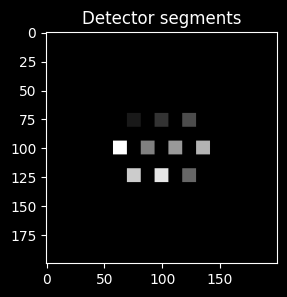

In [74]:
fig, ax0 = plt.subplots(1, 1, figsize=(3, 3))

ax0.set_title(f'Detector segments')
ax0.imshow(DETECTOR_PROCESSOR.segmented_detector, cmap='grey')

plt.show()

#### To visualize detector zones (for further use)

In [75]:
ZONES_HIGHLIGHT_COLOR = 'w'
ZONES_LW = 0.5
selected_detector_mask = DETECTOR_PROCESSOR.segmented_detector.clone().detach()

In [76]:
def get_zones_patches(detector_mask):
    """
    Returns a list of patches to draw zones in final visualisation
    """
    zones_patches = []

    delta = 0.5
    
    for ind_class in range(number_of_classes):
        idx_y, idx_x = (detector_mask == ind_class).nonzero(as_tuple=True)
        
        zone_rect = patches.Rectangle(
            (idx_x[0] - delta, idx_y[0] - delta), 
            idx_x[-1] - idx_x[0] + 2 * delta, idx_y[-1] - idx_y[0] + 2 * delta, 
            linewidth=ZONES_LW, 
            edgecolor=ZONES_HIGHLIGHT_COLOR,
            facecolor='none'
        )
        
        zones_patches.append(zone_rect)

    return zones_patches

# <span style="color:red">4. Training of the network (TODO)</span>

Variables at the moment
- `optical_setup` : `LinearOpticalSetup` – a linear optical network composed of Elements
- `detector_processor` : `DetectorProcessorClf` – this layer process an image from the detector and calculates probabilities of belonging to classes.

In [77]:
DEVICE = 'cpu'
# 'cuda' will be tested in another example

In [78]:
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

'cpu'

## 4.1. Prepare some stuff for training

### <span style="color:red">4.1.1. `DataLoaders` (TODO)</span>

**<span style="color:red">Sources to use:</span>**
[[1]](https://www.science.org/doi/10.1126/science.aat8084) and its [Supplementary Material](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf), [[2]](https://ieeexplore.ieee.org/abstract/document/8732486) 

In [79]:
# TODO: Specify batch sizes for training

In [80]:
train_bs = 20  # a batch size for training set
val_bs = 8

#### Train/Validation split

In [81]:
# TODO: specify a random seed
train_val_split_seed = 40

In [82]:
# mnist_wf_train_ds
train_wf_ds, val_wf_ds = torch.utils.data.random_split(
    dataset=mnist_wf_train_ds,
    lengths=[55000, 5000],  # sizes from the article
    generator=torch.Generator().manual_seed(train_val_split_seed)  # for reproducibility
)

In [83]:
train_wf_loader = torch.utils.data.DataLoader(
    train_wf_ds,
    batch_size=train_bs,
    shuffle=True,
    # num_workers=2,
    drop_last=False,
)

val_wf_loader = torch.utils.data.DataLoader(
    val_wf_ds,
    batch_size=val_bs,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)

### 4.1.2. Optimizer and loss function

Info from a supplementary material of [[1]](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) for MNIST classification:

> We used the stochastic gradient descent algorithm, Adam, to back-propagate the errors and update the
layers of the network to minimize the loss function.

**<span style="color:red">Additional info</span>** from [[2]](https://ieeexplore.ieee.org/abstract/document/8732486):
> a back-propagation method by applying the adaptive moment estimation optimizer (Adam) with a learning rate of $10^{−3}$

In [84]:
LR = 1e-3

In [85]:
def get_adam_optimizer(net):
    return torch.optim.Adam(
        params=net.parameters(),  # NETWORK PARAMETERS!
        lr=LR
    )

In [86]:
loss_func_clf = nn.CrossEntropyLoss()
loss_func_name = 'CE loss'

### 4.1.3. Training and evaluation loops

In [87]:
# we are just importing them from src folder
from src.clf_loops import onn_train_clf, onn_validate_clf

## <span style="color:red">4.2. Training of the optical network (TODO)</span>

### 4.2.1. Before training

> a diffractive layer ... neurons ... were initialized with $\pi$ for phase values and $1$ for amplitude values ...

#### Metrics for Test dataset

In [88]:
test_wf_loader = torch.utils.data.DataLoader(
    mnist_wf_test_ds,
    batch_size=10,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)  # data loader for a test MNIST data

In [89]:
test_losses_0, _, test_accuracy_0 = onn_validate_clf(
    optical_setup.net,  # optical network composed in 3.
    test_wf_loader,  # dataloader of training set
    DETECTOR_PROCESSOR,  # detector processor
    loss_func_clf,
    device=DEVICE,
    show_process=True,
)  # evaluate the model

print(
    'Results before training on TEST set:\n' + 
    f'\t{loss_func_name} : {np.mean(test_losses_0):.6f}\n' +
    f'\tAccuracy : {(test_accuracy_0 * 100):>0.1f} %'
)

validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:12<00:00, 13.75it/s]

Results before training on TEST set:
	CE loss : 2.292468
	Accuracy : 14.5 %


### <span style="color:red"> 4.2.2. Some values for training (TODO)</span>

In [90]:
# TODO: specify values

In [91]:
NUM_EPOCHS = 15

In [92]:
TORCH_SEED = 4  # for reproducability (int)

### <span style="color:red"> 4.2.3. Save all parameters in file (TODO)</span>

In [93]:
today_date = datetime.today().strftime('%d-%m-%Y_%H-%M')  # date for a results folder name

In [94]:
RESULTS_FOLDER = f'results/exp_{today_date}'
RESULTS_FOLDER

'results/exp_23-06-2025_14-57'

#### Conditions

In [95]:
# TODO: maybe add some other parameters

In [96]:
VARIABLES = {    
    'wavelength': working_wavelength,  # working wavelength, in [m]
    'neuron_size': neuron_size,  # size of a pixel for DiffractiveLayers, in [m]
    'mesh_size': ALL_SIZE,  # full size of a layer = numerical mesh
    'use_apertures': USE_APERTURES,  # if we need to add apertures before each DiffractieLayer
    'aperture_size': DETECTOR_SIZE,  # size of each aperture = a detector square for classes zones
    
    # DETECTOR ZONES
    'detector_segment_size': detector_segment_size_m,  # size of each square class zone on a detector, in [m]
    'segments_order': ZONES_ORDER,

    # RANDOM SEEDS
    'train_val_seed': train_val_split_seed,
    'torch_seed': TORCH_SEED,
    
    # NETWORK - SECTION 3 of the notebook
    'free_space_distance': FREE_SPACE_DISTANCE,  # constant free space distance for a network, in [m]
    
    # OPTICAL NETWORK LEARNING - SECTION 4 of the notebook
    'train_batch_size': train_bs,  # batch sizes for training
    'val_batch_size': val_bs,
    'adam_lr': LR,  # learning rate for Adam optimizer
    'number_of_epochs': NUM_EPOCHS,  # number of epochs to train
}

In [97]:
if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

In [98]:
import json
# save experiment conditions (VARIABLES dictionary)
with open(f'{RESULTS_FOLDER}/conditions.json', 'w', encoding ='utf8') as json_file:
    json.dump(VARIABLES, json_file, ensure_ascii = True)

#### Detector mask

In [99]:
torch.save(DETECTOR_MASK, f'{RESULTS_FOLDER}/detector_mask.pt')

### 4.2.4. Training

In [100]:
print_each = 1  # print each n'th epoch info

In [101]:
scheduler = None  # sheduler for a lr tuning during training 

In [102]:
# Recreate a system to restart training!
optical_setup_to_train = get_setup(SIM_PARAMS, apertures=USE_APERTURES)
# Link optimizer to a recreated net!
optimizer_clf = get_adam_optimizer(optical_setup_to_train.net)

In [103]:
# TODO: RUN TRAINING! Look on losses!

In [ ]:
train_epochs_losses = []
val_epochs_losses = []  # to store losses of each epoch

train_epochs_acc = []
val_epochs_acc = []  # to store accuracies

torch.manual_seed(TORCH_SEED)

for epoch in range(NUM_EPOCHS):
    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):
        print(f'Epoch #{epoch + 1}: ', end='')
        show_progress = True
    else:
        show_progress = False

    # TRAIN
    start_train_time = time.time()  # start time of the epoch (train)
    train_losses, _, train_accuracy = onn_train_clf(
        optical_setup_to_train.net,  # optical network composed in 3.
        train_wf_loader,  # dataloader of training set
        DETECTOR_PROCESSOR,  # detector processor
        loss_func_clf,
        optimizer_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # train the model
    mean_train_loss = np.mean(train_losses)
    
    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):  # train info
        print('Training results')
        print(f'\t{loss_func_name} : {mean_train_loss:.6f}')
        print(f'\tAccuracy : {(train_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_train_time:.2f} s')

    # VALIDATION
    start_val_time = time.time()  # start time of the epoch (validation)
    val_losses, _, val_accuracy = onn_validate_clf(
        optical_setup_to_train.net,  # optical network composed in 3.
        val_wf_loader,  # dataloader of validation set
        DETECTOR_PROCESSOR,  # detector processor
        loss_func_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # evaluate the model
    mean_val_loss = np.mean(val_losses)
    
    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):  # validation info
        print('Validation results')
        print(f'\t{loss_func_name} : {mean_val_loss:.6f}')
        print(f'\tAccuracy : {(val_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_val_time:.2f} s')
            
    if scheduler:
        scheduler.step(mean_val_loss) 
    
    # save losses
    train_epochs_losses.append(mean_train_loss)
    val_epochs_losses.append(mean_val_loss)
    # seve accuracies
    train_epochs_acc.append(train_accuracy)
    val_epochs_acc.append(val_accuracy)

Epoch #1: 

train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2750/2750 [08:27<00:00,  5.42it/s]


Training results
	CE loss : 2.089467
	Accuracy : 58.5 %
	------------   507.06 s


validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:33<00:00, 18.88it/s]


Validation results
	CE loss : 1.979181
	Accuracy : 75.5 %
	------------   33.12 s
Epoch #2: 

train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2750/2750 [08:51<00:00,  5.18it/s]


Training results
	CE loss : 1.941359
	Accuracy : 78.4 %
	------------   531.24 s


validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:30<00:00, 20.21it/s]


Validation results
	CE loss : 1.913662
	Accuracy : 81.2 %
	------------   30.93 s
Epoch #3: 

train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2750/2750 [08:46<00:00,  5.22it/s]


Training results
	CE loss : 1.899719
	Accuracy : 81.4 %
	------------   526.84 s


validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:34<00:00, 17.89it/s]


Validation results
	CE loss : 1.888265
	Accuracy : 82.1 %
	------------   34.95 s
Epoch #4: 

train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2750/2750 [08:11<00:00,  5.60it/s]


Training results
	CE loss : 1.881627
	Accuracy : 82.5 %
	------------   491.52 s


validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:29<00:00, 20.87it/s]


Validation results
	CE loss : 1.875697
	Accuracy : 82.9 %
	------------   29.95 s
Epoch #5: 

train:  16%|███████████████████▌                                                                                                          | 427/2750 [01:17<06:19,  6.12it/s]

KeyboardInterrupt: 

### 4.2.5. Saving results

#### Plot and save losses

In [ ]:
# learning curve
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(range(1, NUM_EPOCHS + 1), train_epochs_losses, label='train')
axs[0].plot(range(1, NUM_EPOCHS + 1), val_epochs_losses, linestyle='dashed', label='validation')

axs[1].plot(range(1, NUM_EPOCHS + 1), train_epochs_acc, label='train')
axs[1].plot(range(1, NUM_EPOCHS + 1), val_epochs_acc, linestyle='dashed', label='validation')

axs[0].set_ylabel(loss_func_name)
axs[0].set_xlabel('Epoch')
axs[0].legend()

axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

plt.show()

In [ ]:
# array with all losses
all_lasses_header = ','.join([
    f'{loss_func_name.split()[0]}_train', f'{loss_func_name.split()[0]}_val',
    'accuracy_train', 'accuracy_val'
])
all_losses_array = np.array(
    [train_epochs_losses, val_epochs_losses, train_epochs_acc, val_epochs_acc]
).T

In [ ]:
# filepath to save losses
losses_filepath = f'{RESULTS_FOLDER}/training_curves.csv'

In [ ]:
# saving losses
np.savetxt(
    losses_filepath, all_losses_array,
    delimiter=',', header=all_lasses_header, comments=""
)

#### Save model weights

In [ ]:
# filepath to save the model
model_filepath = f'{RESULTS_FOLDER}/optical_net.pth'

In [ ]:
# saving model
torch.save(optical_setup_to_train.net.state_dict(), model_filepath)

# 5. Load model and estimate perfomance

In [ ]:
LOAD_FOLDER = f'results/...'  # select experiment folder!

## 5.1. Loading of saved results

### 5.1.1. Variables

In [ ]:
with open(f'{RESULTS_FOLDER}/conditions.json') as json_file:
    LOADED_VARIABLES = json.load(json_file)

### 5.1.2. Weights of a model

In [ ]:
# init setup to load weights
optical_setup_loaded = get_setup(SIM_PARAMS, LOADED_VARIABLES['use_apertures'])
# LOAD WEIGHTS for the model
optical_setup_loaded.net.load_state_dict(torch.load(f'{LOAD_FOLDER}/optical_net.pth'))

### 5.1.3. Detector processor

In [ ]:
DETECTOR_MASK_LOADED = torch.load(f'{LOAD_FOLDER}/detector_mask.pt')

In [ ]:
DETECTOR_PROCESSOR_LOADED = DetectorProcessorClf(
    simulation_parameters=SIM_PARAMS,
    num_classes=NUMBER_OF_CLASSES,
    segmented_detector=DETECTOR_MASK_LOADED,
)

### 5.1.4. Trained phase masks visualization

In [ ]:
n_cols = NUM_OF_DIFF_LAYERS  # number of columns for DiffractiveLayer's masks visualization
n_rows = 1

# plot wavefronts phase
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))
ind_diff_layer = 0

cmap = 'gist_stern'  # 'gist_stern' 'rainbow'

for ind_layer, layer in enumerate(optical_setup_loaded.net):
    if isinstance(layer, elements.DiffractiveLayer):  # plot masks for Diffractive layers
        if n_rows > 1:
            ax_this = axs[ind_diff_layer // n_cols][ind_diff_layer % n_cols]
        else:
            ax_this = axs[ind_diff_layer % n_cols]

        ax_this.set_title(f'{ind_diff_layer + 1}. DiffractiveLayer')

        trained_mask = layer.mask.detach()
        
        ax_this.imshow(         
            trained_mask, cmap=cmap,
            vmin=0, vmax=MAX_PHASE
        )
        ind_diff_layer += 1

    # select only a part within apertures!
    x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
    y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
    ax_this.set_xlim([x_frame, x_layer_nodes - x_frame])
    ax_this.set_ylim([y_frame, y_layer_nodes - y_frame])

plt.show()

## 5.2. Calculate metrics on test set for the loaded model

Checking if the loaded model works correctly!

In [ ]:
test_losses_1, _, test_accuracy_1 = onn_validate_clf(
    optical_setup_loaded.net,  # optical network with loaded weights
    test_wf_loader,  # dataloader of training set
    detector_processor,  # detector processor
    loss_func_clf,
    device=DEVICE,
    show_process=True,
)  # evaluate the model

print(
    'Results after training on TEST set:\n' + 
    f'\t{loss_func_name} : {np.mean(test_losses_1):.6f}\n' +
    f'\tAccuracy : {(test_accuracy_1 * 100):>0.1f} %'
)

## 5.3. Example of classification (propagation through the setup)

### 5.3.1. Select a sample to propagate

In [ ]:
# plot an image
# '1' - 3214, good
# '4' - 6152, good
# '6' - 123, good
# '8' - 128, good
# '0' - 3, good
ind_test = 123
cmap = 'hot'

fig, axs = plt.subplots(1, 2, figsize=(2 * 3, 3))

test_wavefront, test_target = mnist_wf_test_ds[ind_test]

axs[0].set_title(f'intensity (id={ind_test})')
axs[0].imshow(test_wavefront.intensity, cmap=cmap)

axs[1].set_title(f'phase')
axs[1].imshow(
    test_wavefront.phase, cmap=cmap,
    vmin=0, vmax=2 * torch.pi
)

plt.show()

In [ ]:
# propagation of the example through the trained network
setup_scheme, test_wavefronts = optical_setup_loaded.stepwise_forward(test_wavefront)

### <span style="color:red"> 5.3.2. Stepwise propagation (TODO)</span>

In [ ]:
# TODO: see what happens with a wavefront

In [ ]:
# TODO: aad your code to see^ how the wavefront propagates through a trained optical network!

# your code... (Hint: we already did it earlier)

### 5.3.3. Detector picture (enlarged)

In [ ]:
# create a figure with subplots
fig, ax_this = plt.subplots(1, 1, figsize=(3, 3.2))

# Detector output (not a wavefront!)
ax_this.set_title('Detector Intensity')
ax_this.imshow(
    test_wavefronts[-1].detach().numpy(), cmap='hot',
    # vmin=0, vmax=1  # uncomment to make the same limits
)

for zone in get_zones_patches(detector_squares_mask):
    # add zone's patches to the axis
    ax_this.add_patch(zone)

# select only a part within apertures! uncomment if needed
# x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
# y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2

# plt.axis([x_frame, x_layer_nodes - x_frame, y_layer_nodes - y_frame, y_frame])

plt.show()

In [ ]:
# get probabilities of an example classification
test_probas = detector_processor.forward(test_wavefronts[-1])
# Comment: forward() method is from DetectorProcessorClf
#          p_i = I(detector_i) / sum_j(I(detector_j))
# Comment: It's another output than for batch_forward, that was used during training!

assert np.isclose(test_probas.sum().item(), 1)

for label, prob in enumerate(test_probas[0]):
    print(f'{label} : {prob * 100:.2f}%')

## 5.3. Confusion matrix

### 5.3.1. Predict all Test dataset and save all results

In [ ]:
targets_test_lst = []
preds_test_lst = []  # lists of targets and model predictioons

# loop over the test dataset
for ind, (wavefront_this, target_this) in enumerate(tqdm(mnist_wf_test_ds)):
    optical_setup_loaded.net.eval()
    
    batch_wavefronts = torch.unsqueeze(wavefront_this, 0)
    batch_labels = torch.unsqueeze(torch.tensor(target_this), 0)  # to use forwards for batches
    
    with torch.no_grad():
        detector_output = optical_setup_loaded.net(batch_wavefronts)
        # process a detector image
        batch_probas = DETECTOR_PROCESSOR_LOADED.batch_forward(detector_output)

        for ind_in_batch in range(batch_labels.size()[0]):
            label_this = batch_labels[ind_in_batch].item()  # true label
            
            targets_test_lst.append(label_this)
            preds_test_lst.append(batch_probas[ind_in_batch].argmax().item())
            

### <span style="color:red"> 5.3.2. Confusion matrix (TODO) </span>

In [ ]:
# TODO: fill the confusion matrix!

In [ ]:
# ordinary confusion matrix
confusion_matrix = torch.zeros(
    size=(mat_y_size, mat_x_size),  # TODO: What is the size of the matrix?
    dtype=torch.int32
)

for ind in range(len(mnist_wf_test_ds)):
    confusion_matrix[targets_test_lst[ind], preds_test_lst[ind]] += 1

#### Plot confusion matrix

In [ ]:
fig, ax0 = plt.subplots(1, 1, figsize=(6, 5))

# CONFUSION MATRIX
ax0.set_title('Confusion matrix')
ax0.matshow(confusion_matrix, cmap='Blues')

for i in range(NUMBER_OF_CLASSES):
    for j in range(NUMBER_OF_CLASSES):
        val = confusion_matrix[j, i].item()
        ax0.text(
            i, j, str(val),
            va='center', ha='center', 
            c='k', fontsize=9
        )

ax0.set_ylabel('Target')
ax0.set_xlabel('Predicted')

ax0.set_xticks(range(number_of_classes))
ax0.set_yticks(range(number_of_classes))

plt.show()

# save figure
# fig.savefig(f'{LOAD_FOLDER}/confusion_matrix.png', bbox_inches='tight')

In [ ]:
# TODO: make some conclusions...